In [1]:
# dependencies
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
# check available device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = "mps"  # Apple GPU
else:
    device = torch.device("cpu")
print(f"Current device: {device}")

Current device: cpu


In [3]:
# helper function to process data
def load_data(data_frame, feature_columns, target_column):
    """
    Load and prepare earthquake data for training and testing
    """
    # Split data into train and test
    data_split = int(len(data_frame) * 0.8) # train ratio 0.8
    training_data, test_data = data_frame[:data_split], data_frame[data_split:]
    
    # Prepare features and y values for training set
    X_train = training_data[feature_columns].values.astype(np.float32)
    y_train = training_data[target_column].values
    
    # Prepare features and y values for test set
    X_test = test_data[feature_columns].values.astype(np.float32)
    y_test = test_data[target_column].values

    # Standardize features
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # Standardize y values
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)) # standard scaler needs 2D input
    y_train_scaled = y_train_scaled.reshape(-1) # convert back to 1D
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)) 
    y_test_scaled = y_test_scaled.reshape(-1)
    
    print(f"Current selected features: {feature_columns}")
    print(f"Current y column: {target_column}")
    print(f"Scaled training dataset shape: {X_train_scaled.shape}")
    print(f"Scaled test dataset shape: {X_test_scaled.shape}")
    print(f"First 5 values of the first feature in train set (original): {X_train[0, :5]}")
    print(f"First 5 values of the first feature in train set (scaled): {X_train_scaled[0, :5]}")
    print(f"First 5 y values in train set (original): {y_train[:5]}")
    print(f"First 5 y values in train set (scaled): {y_train_scaled[:5]}")
    
    # Create TensorDatasets
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test_scaled)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    return train_loader, test_loader, feature_scaler, y_scaler

In [4]:
# load data
data_frame = pd.read_csv('./datasets/earthquake_1995-2023.csv')
feature_columns = ['magnitude', 'cdi', 'mmi', 'tsunami', 'dmin', 'gap', 'depth', 'latitude', 'longitude']
target_column = 'sig'

train_dataloader, test_dataloader, feature_scaler, y_scaler = load_data(data_frame, feature_columns, target_column)
# print(len(train_dataloader), len(test_dataloader))

Current selected features: ['magnitude', 'cdi', 'mmi', 'tsunami', 'dmin', 'gap', 'depth', 'latitude', 'longitude']
Current y column: sig
Scaled training dataset shape: (800, 9)
Scaled test dataset shape: (200, 9)
First 5 values of the first feature in train set (original): [6.5   7.    4.    0.    7.177]
First 5 values of the first feature in train set (scaled): [-0.99331695  0.80337083 -1.2956126  -0.8271702   2.5880444 ]
First 5 y values in train set (original): [657 775 899 860 820]
First 5 y values in train set (scaled): [-0.65491897 -0.2946666   0.08390369 -0.03516277 -0.15728222]


In [5]:
# create a model
class EarthquakeModel(nn.Module):
    def __init__(self, feature_columns) -> None:
        super(EarthquakeModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=len(feature_columns), out_features=64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [6]:
# test code
model = EarthquakeModel(feature_columns)
model.to(device) # load it to the current device
print(model)
print(f"Using {device} to train model")
test_input = (16, 9) # batch size=16, # of features=9
summary(model, input_size=test_input)

EarthquakeModel(
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)
Using cpu to train model


Layer (type:depth-idx)                   Output Shape              Param #
EarthquakeModel                          [16, 1]                   --
├─Sequential: 1-1                        [16, 1]                   --
│    └─Linear: 2-1                       [16, 64]                  640
│    └─ReLU: 2-2                         [16, 64]                  --
│    └─Dropout: 2-3                      [16, 64]                  --
│    └─Linear: 2-4                       [16, 32]                  2,080
│    └─ReLU: 2-5                         [16, 32]                  --
│    └─Dropout: 2-6                      [16, 32]                  --
│    └─Linear: 2-7                       [16, 16]                  528
│    └─ReLU: 2-8                         [16, 16]                  --
│    └─Linear: 2-9                       [16, 1]                   17
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pas

In [7]:
# set up hyperparameters
epochs = 30
learning_rate = 0.001
w_decay = 0.0001 # L2 regularization

loss = nn.MSELoss() # Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay) # Adam optimizer

In [8]:
# define a training function
def train(model, train_dataloader, epoch, loss_function, optimizer):
    model.train()

    train_loss = 0.0 # a loss in training one batch

    for X_batch, y_batch in train_dataloader:
        # load this batch data into the current device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # reset the gradient on every batch to calculate new gradient
        optimizer.zero_grad()

        # get the prediction with the current batch
        train_predictions = model(X_batch).squeeze()

        # ensure y_batch is float to be suitable for regression task
        y_batch = y_batch.float().squeeze()
        
        # use the given loss function to calculate the train loss
        loss = loss_function(train_predictions, y_batch)

        # update the weight using the gradient descent with the current optimizer, Adam
        loss.backward()
        optimizer.step()

        # update training loss
        train_loss += loss.item()

    # get the average loss in training for the current epoch and 
    # print out to see how this training is going
    average_train_loss_in_epoch = train_loss / len(train_dataloader)
    print(f"Epoch: {epoch}: Train Loss = {average_train_loss_in_epoch:.4f}")

    return average_train_loss_in_epoch

In [9]:
# define a test function
def test(model, test_dataloader, loss_function, y_scaler):
    model.eval()

    test_loss = 0.0 # a prediction loss between y hat and y truth in this batch
    y_pred = [] # a list to collect y hats
    y_true = []
    
    # disable gradient update to save memory
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            # load this batch data into the current device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # ensure y_batch is float to be suitable for regression task
            y_batch = y_batch.float().squeeze()

            # get the prediction with the current batch
            test_predictions = model(X_batch).squeeze()

            # use the given loss function to calculate the test loss
            loss = loss_function(test_predictions, y_batch)
            test_loss += loss.item()

            # it'd be better to load back to cpu and then numpy for the future task
            # e.g. plotting
            y_pred.extend(test_predictions.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    # Calculate average test loss on scaled values
    average_test_loss = test_loss / len(test_dataloader)
    print(f"Test Loss: {average_test_loss:.4f}")

    # Convert predictions and true values back to the original scale
    y_pred_original = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)) # StandardScaler needs 2D array input
    y_pred_original = y_pred_original.flatten() # convert back to 1D array
    y_true_original = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1))
    y_true_original = y_true_original.flatten()

    return average_test_loss, y_true_original, y_pred_original

Epoch: 1: Train Loss = 0.9811
Epoch: 2: Train Loss = 0.8060
Epoch: 3: Train Loss = 0.6062
Epoch: 4: Train Loss = 0.4956
Epoch: 5: Train Loss = 0.4466
Epoch: 6: Train Loss = 0.4397
Epoch: 7: Train Loss = 0.4226
Epoch: 8: Train Loss = 0.4308
Epoch: 9: Train Loss = 0.4437
Epoch: 10: Train Loss = 0.4267
Epoch: 11: Train Loss = 0.4160
Epoch: 12: Train Loss = 0.3964
Epoch: 13: Train Loss = 0.4176
Epoch: 14: Train Loss = 0.4162
Epoch: 15: Train Loss = 0.4086
Epoch: 16: Train Loss = 0.3871
Epoch: 17: Train Loss = 0.3994
Epoch: 18: Train Loss = 0.3840
Epoch: 19: Train Loss = 0.4075
Epoch: 20: Train Loss = 0.3941
Epoch: 21: Train Loss = 0.4127
Epoch: 22: Train Loss = 0.3823
Epoch: 23: Train Loss = 0.3739
Epoch: 24: Train Loss = 0.3646
Epoch: 25: Train Loss = 0.3883
Epoch: 26: Train Loss = 0.3821
Epoch: 27: Train Loss = 0.3361
Epoch: 28: Train Loss = 0.3731
Epoch: 29: Train Loss = 0.3559
Epoch: 30: Train Loss = 0.3775


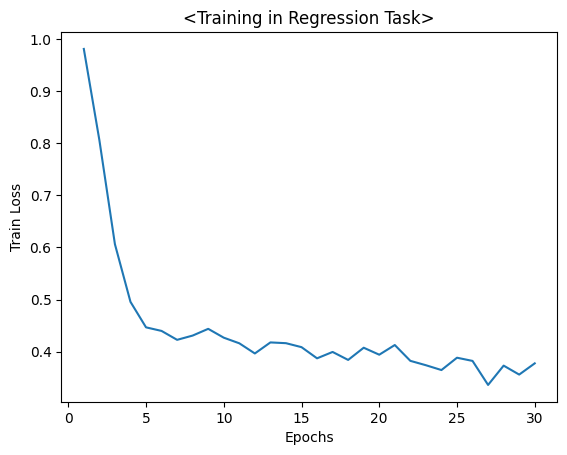

In [10]:
# train the model
num_of_epochs = []
train_losses = []

for epoch in range(1, epochs+1):
    num_of_epochs.append(epoch)
    current_train_loss = train(model, train_dataloader, epoch, loss, optimizer)
    train_losses.append(current_train_loss)

# visualize the training process
# print(f"len(num_of_epochs): {len(num_of_epochs)}, len(train_losses): {len(train_losses)}")
fig, axis = plt.subplots()
axis.set_title("<Training in Regression Task>")
axis.plot(num_of_epochs, train_losses)
axis.set_xlabel("Epochs")
axis.set_ylabel("Train Loss")
plt.show()

In [11]:
# test the model
test_loss, y_true_original, y_pred_original = test(model, test_dataloader, loss, y_scaler)

Test Loss: 0.0143


Test Metrics (Original Scale):
MSE: 1577.5564
MAE: 23.7524


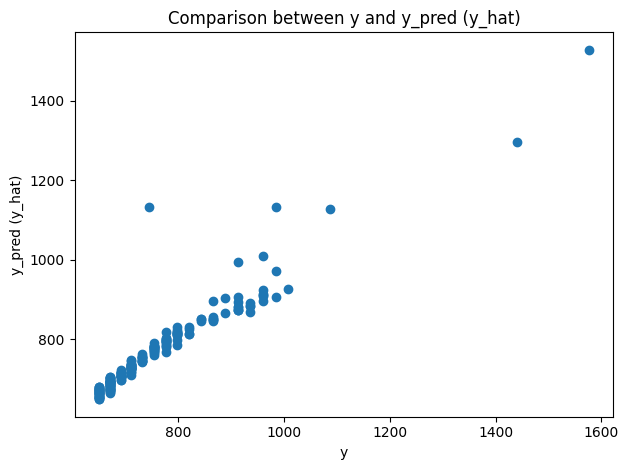

In [12]:
# evaluate the result (original scale) using metrics
mse = mean_squared_error(y_true_original, y_pred_original)
mae = mean_absolute_error(y_true_original, y_pred_original)

print(f"Test Metrics (Original Scale):")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

# visualize the test result
fig, axis = plt.subplots()
axis.scatter(y_true_original, y_pred_original)
axis.set_xlabel("y")
axis.set_ylabel("y_pred (y_hat)")
axis.set_title("Comparison between y and y_pred (y_hat)")

plt.tight_layout()
plt.show()